In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import time
import os
import sys
from tqdm import tqdm
import shutil
import pyarrow.parquet as pq
import pyarrow as pa
from uuid import uuid4
import warnings
import subprocess
warnings.filterwarnings('ignore')

# Enhanced PyTorch and CUDA diagnostics
def check_cuda_environment():
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. This notebook requires a GPU.")
    
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    
    # Test CUDA operation
    try:
        test_tensor = torch.tensor([1.0, 2.0, 3.0], device='cuda')
        test_result = test_tensor + 1
        print(f"CUDA test operation successful: {test_result}")
    except Exception as e:
        print(f"CUDA test operation failed: {e}")
        raise
    
    # Check NVIDIA driver and CUDA toolkit
    try:
        nvidia_smi = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        print("NVIDIA-SMI output:")
        print(nvidia_smi.stdout)
    except Exception as e:
        print(f"Failed to run nvidia-smi: {e}")
    
    # Check GPU memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 2**30:.2f} GiB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 2**30:.2f} GiB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved(0) / 2**30:.2f} GiB")

try:
    check_cuda_environment()
except Exception as e:
    print(f"Error with PyTorch or CUDA setup: {e}")
    print("Try reinstalling PyTorch: pip install torch==2.7.0 --index-url https://download.pytorch.org/whl/cu124")
    raise

# Environment diagnostics
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print(f"PATH: {os.environ.get('PATH')}")
print(f"Available disk space: {shutil.disk_usage('/').free / (2**30):.2f} GiB")

# Check for module shadowing
if os.path.exists('/workspace/XAI/torch.py') or os.path.exists('/workspace/XAI/torch.pyc'):
    print("Warning: Found 'torch.py' or 'torch.pyc' in /workspace/XAI. Please rename or remove it.")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (GPU only)
device = torch.device("cuda")
print(f"Using device: {device}")

# Clear GPU memory
torch.cuda.empty_cache()
print("Cleared GPU memory cache")

PyTorch version: 2.7.0+cu118
CUDA available: True
CUDA version: 11.8
GPU device: NVIDIA RTX A6000
GPU count: 1
Current device: 0
CUDA test operation successful: tensor([2., 3., 4.], device='cuda:0')
NVIDIA-SMI output:
Sat May 10 16:59:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:D5:00.0 Off |                    0 |
| 30%   33C   

In [2]:
def load_data(data_dir="/workspace/data", file_name="merged_data.csv"):
    file_path = os.path.join(data_dir, file_name)
    alt_path = "/workspace/XAI-1/Predict Future Sales/merged_data.csv"
    
    if not os.path.exists(file_path):
        if os.path.exists(alt_path):
            file_path = alt_path
        else:
            raise FileNotFoundError(f"File not found at {file_path} or {alt_path}")
    
    try:
        data = pd.read_csv(file_path)
        print(f"Loaded data from {file_path}")
        print(f"Dataset shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
    except Exception as e:
        raise RuntimeError(f"Failed to load {file_path}: {e}")
    
    # Verify expected columns
    expected_columns = ['date', 'shop_id', 'item_id', 'item_name', 'item_cnt_day', 'item_price', 'item_category_id', 'shop_name', 'item_category_name', 'date_block_num']
    missing_cols = [col for col in expected_columns if col not in data.columns]
    if missing_cols:
        print(f"Warning: Missing expected columns: {missing_cols}")
    
    return data

# Load data
data = load_data()

Loaded data from /workspace/XAI-1/Predict Future Sales/merged_data.csv
Dataset shape: (2935849, 10)
Columns: ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']


In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import RobustScaler
import pickle
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('/workspace/processed_data/preprocess.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def preprocess_data(data):
    start_time = time.time()
    
    # Early column dropping
    keep_cols = ['date', 'date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day', 'item_price']
    data = data[keep_cols]
    logger.info(f"Initial columns kept: {data.columns.tolist()}")
    
    # Optimize dtypes early
    data = data.astype({
        'date_block_num': 'int16',
        'shop_id': 'int32',
        'item_id': 'int32',
        'item_category_id': 'int32',
        'item_cnt_day': 'float32',
        'item_price': 'float32'
    }, errors='ignore')
    
    # Convert date to datetime
    step_time = time.time()
    data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y', errors='coerce')
    data = data[data['date'].notna()]
    logger.info(f"Records after removing invalid dates: {len(data)}")
    logger.info(f"Date conversion time: {time.time() - step_time:.2f} seconds")
    
    # Remove duplicates
    step_time = time.time()
    logger.info(f"Duplicate records: {data.duplicated().sum()}")
    data = data.drop_duplicates()
    logger.info(f"Duplicate removal time: {time.time() - step_time:.2f} seconds")
    
    # Verify no missing values
    step_time = time.time()
    logger.info("\nMissing values before processing:")
    logger.info(data[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id']].isna().sum().to_string())
    if data[['item_cnt_day', 'item_price']].isna().any().any():
        raise ValueError("Unexpected missing values in item_cnt_day or item_price.")
    logger.info(f"Missing value check time: {time.time() - step_time:.2f} seconds")
    
    # Winsorization
    def winsorize_sales_chunk(chunk):
        chunk = chunk.sort_values(['shop_id', 'item_id', 'date'])
        rolling_stats = chunk.groupby(['shop_id', 'item_id'])['item_cnt_day'].rolling(window=30, min_periods=1).agg(['mean', 'std']).reset_index()
        rolling_stats['upper_bound'] = rolling_stats['mean'] + 3 * rolling_stats['std']
        rolling_stats['upper_bound'] = rolling_stats['upper_bound'].fillna(chunk['item_cnt_day'].quantile(0.99))
        
        chunk = chunk.merge(rolling_stats[['upper_bound']], left_index=True, right_index=True)
        chunk['item_cnt_day_winsor'] = np.minimum(chunk['item_cnt_day'], chunk['upper_bound'])
        chunk['is_outlier'] = chunk['item_cnt_day'] > chunk['upper_bound']
        return chunk
    
    step_time = time.time()
    chunk_size = 500000
    try:
        data = winsorize_sales_chunk(data)
    except MemoryError:
        logger.info("MemoryError during Winsorization. Using chunked processing...")
        chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
        data = pd.concat([winsorize_sales_chunk(chunk) for chunk in chunks], ignore_index=True)
    outlier_count = data['is_outlier'].sum()
    logger.info(f"Outliers detected: {outlier_count} ({(outlier_count / len(data) * 100):.2f}%)")
    data = data.drop(columns=['is_outlier', 'upper_bound'])
    logger.info(f"Winsorization time: {time.time() - step_time:.2f} seconds")
    
    # Handle negative sales
    step_time = time.time()
    data['returns'] = data['item_cnt_day_winsor'].apply(lambda x: abs(x) if x < 0 else 0)
    data['item_cnt_day_winsor'] = data['item_cnt_day_winsor'].apply(lambda x: max(0, x))
    logger.info(f"Negative sales after processing: {(data['item_cnt_day_winsor'] < 0).sum()}")
    logger.info(f"Negative sales handling time: {time.time() - step_time:.2f} seconds")
    
    # Aggregate to monthly level
    step_time = time.time()
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    monthly_sales = data.groupby([
        'year', 'month', 'shop_id', 'item_id', 'item_category_id', 'date_block_num'
    ], sort=False).agg({
        'item_cnt_day_winsor': 'sum',
        'returns': 'sum',
        'item_price': 'mean'
    }).reset_index()
    monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))
    logger.info(f"Monthly sales shape: {monthly_sales.shape}")
    logger.info(f"Aggregation time: {time.time() - step_time:.2f} seconds")
    
    # Create lag features
    def create_lag_features(df):
        df = df.sort_values(['shop_id', 'item_id', 'date'])
        for lag in [1, 2, 3]:
            df[f'lag_sales_{lag}'] = df.groupby(['shop_id', 'item_id'], sort=False)['item_cnt_day_winsor'].shift(lag)
            df[f'lag_returns_{lag}'] = df.groupby(['shop_id', 'item_id'], sort=False)['returns'].shift(lag)
            df[f'lag_price_{lag}'] = df.groupby(['shop_id', 'item_id'], sort=False)['item_price'].shift(lag)
        return df
    
    step_time = time.time()
    try:
        monthly_sales = create_lag_features(monthly_sales)
    except MemoryError:
        logger.info("MemoryError during lag feature creation. Using chunked processing...")
        chunks = [monthly_sales[i:i + chunk_size] for i in range(0, len(monthly_sales), chunk_size)]
        monthly_sales = pd.concat([create_lag_features(chunk) for chunk in chunks], ignore_index=True)
    
    # Fill NA instead of dropping
    numerical_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3'
    ]
    monthly_sales[numerical_cols] = monthly_sales[numerical_cols].fillna(0)
    logger.info(f"Records after creating lag features and filling NA: {len(monthly_sales)}")
    logger.info(f"Lag feature creation time: {time.time() - step_time:.2f} seconds")
    
    # Save unscaled data for debugging
    monthly_sales.to_parquet('/workspace/processed_data/monthly_sales_unscaled.parquet')
    logger.info("Saved unscaled data to /workspace/processed_data/monthly_sales_unscaled.parquet")
    
    # Robust scaling (fixed)
    step_time = time.time()
    scaler = RobustScaler()
    try:
        # Fit scaler on training data (date_block_num < 31)
        train_data = monthly_sales[monthly_sales['date_block_num'] < 31][numerical_cols]
        logger.info(f"Training data shape for scaler fit: {train_data.shape}")
        logger.info("Pre-scaling training data stats:")
        for col in numerical_cols:
            mean = train_data[col].mean()
            std = train_data[col].std()
            logger.info(f"  {col}: mean={mean:.6f}, std={std:.6f}")
        scaler.fit(train_data)
        logger.info(f"Scaler center: {scaler.center_}")
        logger.info(f"Scaler scale: {scaler.scale_}")
        # Apply to all data
        scaled_data = scaler.transform(monthly_sales[numerical_cols])
        monthly_sales.loc[:, numerical_cols] = scaled_data
        # Verify scaling
        logger.info("Post-scaling numerical means:")
        for col in numerical_cols:
            mean = monthly_sales[col].mean()
            std = monthly_sales[col].std()
            logger.info(f"  {col}: mean={mean:.6f}, std={std:.6f}")
        # Check for NaNs
        if monthly_sales[numerical_cols].isna().any().any():
            raise ValueError("NaN values introduced during scaling.")
        # Save scaler
        with open('/workspace/processed_data/scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    except Exception as e:
        logger.error(f"Error in scaling: {e}")
        raise
    logger.info(f"Robust scaling time: {time.time() - step_time:.2f} seconds")
    
    # Keep only necessary columns
    step_time = time.time()
    keep_cols = numerical_cols + ['shop_id', 'item_id', 'item_category_id', 'date', 'date_block_num']
    monthly_sales = monthly_sales[keep_cols]
    logger.info(f"Features after preprocessing: {len(monthly_sales.columns)}")
    
    # Check for duplicate columns
    duplicate_cols = monthly_sales.columns[monthly_sales.columns.duplicated()].tolist()
    if duplicate_cols:
        logger.warning(f"Duplicate columns found: {duplicate_cols}. Removing duplicates...")
        monthly_sales = monthly_sales.loc[:, ~monthly_sales.columns.duplicated()]
        logger.info(f"Features after removing duplicates: {len(monthly_sales.columns)}")
    
    # Optimize final dtypes
    monthly_sales = monthly_sales.astype({
        'item_cnt_day_winsor': 'float32', 'returns': 'float32', 'item_price': 'float32',
        'lag_sales_1': 'float32', 'lag_sales_2': 'float32', 'lag_sales_3': 'float32',
        'lag_returns_1': 'float32', 'lag_returns_2': 'float32', 'lag_returns_3': 'float32',
        'lag_price_1': 'float32', 'lag_price_2': 'float32', 'lag_price_3': 'float32',
        'shop_id': 'int32', 'item_id': 'int32', 'item_category_id': 'int32',
        'date_block_num': 'int16'
    }, errors='ignore')
    logger.info(f"Final column selection and dtype optimization time: {time.time() - step_time:.2f} seconds")
    
    logger.info(f"Total preprocessing time: {time.time() - start_time:.2f} seconds")
    return monthly_sales

# Preprocess data
monthly_sales = preprocess_data(data)

2025-05-10 16:59:49 - INFO - Initial columns kept: ['date', 'date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day', 'item_price']


2025-05-10 16:59:49 - INFO - Records after removing invalid dates: 2935849
2025-05-10 16:59:49 - INFO - Date conversion time: 0.34 seconds
2025-05-10 16:59:50 - INFO - Duplicate records: 6
2025-05-10 16:59:51 - INFO - Duplicate removal time: 1.48 seconds
2025-05-10 16:59:51 - INFO - 
Missing values before processing:
2025-05-10 16:59:51 - INFO - date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
2025-05-10 16:59:51 - INFO - Missing value check time: 0.06 seconds
2025-05-10 17:00:10 - INFO - Outliers detected: 170214 (5.80%)
2025-05-10 17:00:10 - INFO - Winsorization time: 19.32 seconds
2025-05-10 17:00:12 - INFO - Negative sales after processing: 0
2025-05-10 17:00:12 - INFO - Negative sales handling time: 1.60 seconds
2025-05-10 17:00:13 - INFO - Monthly sales shape: (1609122, 10)
2025-05-10 17:00:13 - INFO - Aggregation time: 0.69 seconds
2025-05-10 17:00:13 - INFO - Records after c

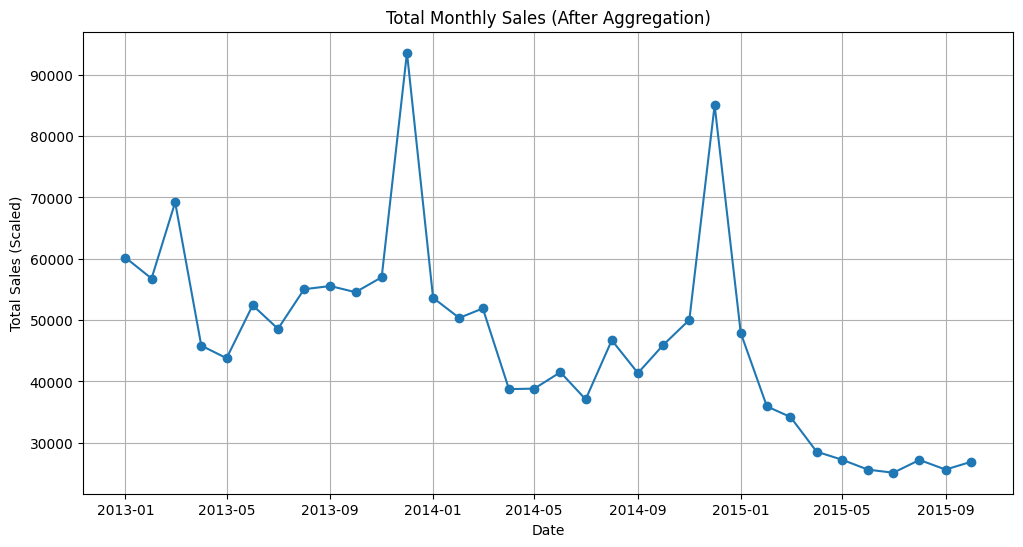

In [4]:
monthly_totals = monthly_sales.groupby('date')['item_cnt_day_winsor'].sum()
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals.index, monthly_totals.values, marker='o')
plt.title('Total Monthly Sales (After Aggregation)')
plt.xlabel('Date')
plt.ylabel('Total Sales (Scaled)')
plt.grid(True)
plt.show()
plt.close()


In [5]:
import pandas as pd
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('/workspace/processed_data/split.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def split_data(data):
    logger.info("Starting data splitting")
    
    expected_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3',
        'shop_id', 'item_id', 'item_category_id', 'date', 'date_block_num'
    ]
    missing_cols = [col for col in expected_cols if col not in data.columns]
    if missing_cols:
        logger.error(f"Missing columns in data: {missing_cols}")
        raise ValueError(f"Missing columns in data: {missing_cols}")
    
    date_block_counts = data['date_block_num'].value_counts().sort_index()
    logger.info("date_block_num distribution:")
    logger.info(date_block_counts.to_string())
    
    if not (data['date_block_num'] == 33).any():
        logger.error("No data for date_block_num == 33 (October 2015).")
        raise ValueError("No data for date_block_num == 33 (October 2015).")
    
    try:
        train_data = data[data['date_block_num'] < 31]
        val_data = data[(data['date_block_num'] >= 31) & (data['date_block_num'] <= 32)]
        test_data = data[data['date_block_num'] == 33]
    except Exception as e:
        logger.error(f"Error in splitting: {e}")
        raise
    
    train_pairs = train_data[['shop_id', 'item_id']].drop_duplicates()
    val_pairs = val_data[['shop_id', 'item_id']].drop_duplicates()
    test_pairs = test_data[['shop_id', 'item_id']].drop_duplicates()
    overlap_train_val = train_pairs.merge(val_pairs, on=['shop_id', 'item_id'], how='inner').shape[0]
    overlap_train_test = train_pairs.merge(test_pairs, on=['shop_id', 'item_id'], how='inner').shape[0]
    logger.info(f"Shop-item overlap between train and val: {overlap_train_val}")
    logger.info(f"Shop-item overlap between train and test: {overlap_train_test}")
    
    numerical_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3'
    ]
    categorical_cols = ['shop_id', 'item_id', 'item_category_id']
    feature_cols = numerical_cols + categorical_cols + ['date_block_num']
    
    X_train = train_data[feature_cols]
    y_train = train_data['item_cnt_day_winsor']
    X_val = val_data[feature_cols]
    y_val = val_data['item_cnt_day_winsor']
    X_test = test_data[feature_cols]
    y_test = test_data['item_cnt_day_winsor']
    
    if not X_train.shape[0]:
        logger.error("Training set is empty.")
        raise ValueError("Training set is empty.")
    if not X_val.shape[0]:
        logger.error("Validation set is empty.")
        raise ValueError("Validation set is empty.")
    if not X_test.shape[0]:
        logger.error("Test set is empty.")
        raise ValueError("Test set is empty.")
    
    logger.info(f"Training set size: {X_train.shape[0]} records")
    logger.info(f"Validation set size: {X_val.shape[0]} records")
    logger.info(f"Test set size: {X_test.shape[0]} records")
    logger.info(f"Training sales mean: {y_train.mean():.4f}, std: {y_train.std():.4f}")
    logger.info(f"Validation sales mean: {y_val.mean():.4f}, std: {y_val.std():.4f}")
    logger.info(f"Test sales mean: {y_test.mean():.4f}, std: {y_test.std():.4f}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(monthly_sales)

2025-05-10 17:00:16 - INFO - Starting data splitting
2025-05-10 17:00:16 - INFO - date_block_num distribution:
2025-05-10 17:00:16 - INFO - date_block_num
0     63224
1     59935
2     63977
3     54638
4     53296
5     56196
6     58035
7     58022
8     51575
9     51090
10    51460
11    66276
12    53320
13    47704
14    49291
15    44740
16    45766
17    46481
18    45756
19    46439
20    40423
21    42595
22    45755
23    59275
24    46775
25    41390
26    40464
27    32875
28    32220
29    31909
30    33527
31    33486
32    29678
33    31529
2025-05-10 17:00:16 - INFO - Shop-item overlap between train and val: 39403
2025-05-10 17:00:16 - INFO - Shop-item overlap between train and test: 21116
2025-05-10 17:00:16 - INFO - Training set size: 1514429 records
2025-05-10 17:00:16 - INFO - Validation set size: 63164 records
2025-05-10 17:00:16 - INFO - Test set size: 31529 records
2025-05-10 17:00:16 - INFO - Training sales mean: 0.9894, std: 3.1360
2025-05-10 17:00:16 - INFO -

In [6]:
import os
import shutil
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import logging
import subprocess

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('/workspace/processed_data/save.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def save_datasets(X_train, y_train, X_val, y_val, X_test, y_test, output_dir="."):
    logger.info("Starting dataset saving")
    os.makedirs(output_dir, exist_ok=True)
    
    # Check disk space
    total, used, free = shutil.disk_usage('/')
    free_gb = free / (2**30)
    logger.info(f"Available disk space: {free_gb:.2f} GiB")
    if free_gb < 5:
        logger.error("Low disk space. Need >5 GiB.")
        raise ValueError("Low disk space. Need >5 GiB.")
    
    def save_parquet(df, filename, chunk_size=100000):
        try:
            duplicate_cols = df.columns[df.columns.duplicated()].tolist()
            if duplicate_cols:
                logger.error(f"Duplicate columns in {filename}: {duplicate_cols}")
                raise ValueError(f"Duplicate columns in {filename}: {duplicate_cols}")
            filepath = os.path.join(output_dir, filename)
            table = pa.Table.from_pandas(df)
            pq.write_table(table, filepath, compression='zstd', row_group_size=chunk_size)
            # Verify file exists
            if not os.path.exists(filepath):
                logger.error(f"Failed to save {filename}: File does not exist")
                raise OSError(f"Failed to save {filename}: File does not exist")
            # Set permissions
            os.chmod(filepath, 0o666)
            # Verify row count
            written = pd.read_parquet(filepath)
            if written.shape[0] != df.shape[0]:
                logger.error(f"Row count mismatch in {filename}: expected {df.shape[0]}, got {written.shape[0]}")
                raise ValueError(f"Row count mismatch in {filename}: expected {df.shape[0]}, got {written.shape[0]}")
            # Log file size and permissions
            file_size = os.path.getsize(filepath) / (2**20)  # MB
            permissions = oct(os.stat(filepath).st_mode)[-3:]
            logger.info(f"Saved and verified {filename} at {filepath}, size: {file_size:.2f} MB, permissions: {permissions}")
            # Force filesystem sync
            subprocess.run(['sync'], check=True)
            logger.info(f"Filesystem synced for {filename}")
        except Exception as e:
            logger.error(f"Error saving {filename}: {e}")
            raise
    
    # Save datasets
    save_parquet(X_train, 'X_train_processed.parquet')
    save_parquet(y_train.to_frame(), 'y_train_processed.parquet')
    save_parquet(X_val, 'X_val_processed.parquet')
    save_parquet(y_val.to_frame(), 'y_val_processed.parquet')
    save_parquet(X_test, 'X_test_processed.parquet')
    save_parquet(y_test.to_frame(), 'y_test_processed.parquet')
    
    # Create dummy file to trigger VSCode refresh
    dummy_file = os.path.join(output_dir, '.vscode_refresh_trigger')
    with open(dummy_file, 'w') as f:
        f.write('Trigger VSCode refresh')
    os.chmod(dummy_file, 0o666)
    logger.info(f"Created dummy file {dummy_file} to trigger VSCode refresh")
    
    # List files
    logger.info("Listing files in output directory:")
    for f in os.listdir(output_dir):
        if f.endswith('.parquet'):
            file_path = os.path.join(output_dir, f)
            file_size = os.path.getsize(file_path) / (2**20)  # MB
            permissions = oct(os.stat(file_path).st_mode)[-3:]
            logger.info(f"  {f}, size: {file_size:.2f} MB, permissions: {permissions}")
    
    # Verify workspace path
    workspace_path = os.path.abspath('/workspace')
    logger.info(f"Current workspace path: {workspace_path}")
    logger.info("Ensure /workspace/processed_data is in VSCode's workspace")
    
save_datasets(X_train, y_train, X_val, y_val, X_test, y_test)

2025-05-10 17:00:16 - INFO - Starting dataset saving
2025-05-10 17:00:16 - INFO - Available disk space: 16.25 GiB


2025-05-10 17:00:17 - INFO - Saved and verified X_train_processed.parquet at ./X_train_processed.parquet, size: 15.50 MB, permissions: 666
2025-05-10 17:00:17 - INFO - Filesystem synced for X_train_processed.parquet
2025-05-10 17:00:18 - INFO - Saved and verified y_train_processed.parquet at ./y_train_processed.parquet, size: 5.12 MB, permissions: 666
2025-05-10 17:00:18 - INFO - Filesystem synced for y_train_processed.parquet
2025-05-10 17:00:18 - INFO - Saved and verified X_val_processed.parquet at ./X_val_processed.parquet, size: 0.76 MB, permissions: 666
2025-05-10 17:00:18 - INFO - Filesystem synced for X_val_processed.parquet
2025-05-10 17:00:18 - INFO - Saved and verified y_val_processed.parquet at ./y_val_processed.parquet, size: 0.22 MB, permissions: 666
2025-05-10 17:00:18 - INFO - Filesystem synced for y_val_processed.parquet
2025-05-10 17:00:18 - INFO - Saved and verified X_test_processed.parquet at ./X_test_processed.parquet, size: 0.39 MB, permissions: 666
2025-05-10 17:0

In [9]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pyarrow.parquet as pq
import polars as pl
from tqdm import tqdm
from uuid import uuid4
import logging
import pickle
import subprocess

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('./ha_lstm_forecasting.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# GPU Configuration - Added environment variables for performance tuning
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  # Disable launch blocking for better parallelization
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use first GPU
os.environ['OMP_NUM_THREADS'] = '8'  # Control OpenMP threads
os.environ['MKL_NUM_THREADS'] = '8'  # Control MKL threads

# Set device to GPU with performance settings
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes
    torch.backends.cuda.matmul.allow_tf32 = True  # Enable TensorFloat32
    torch.backends.cudnn.allow_tf32 = True  # Enable TensorFloat32
    logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    logger.info("Using CPU (no GPU available)")

# Add GPU memory state reporting function
def report_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3)
        reserved = torch.cuda.memory_reserved() / (1024**3)
        try:
            smi_output = subprocess.check_output(['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv']).decode()
            gpu_util = int(smi_output.split('\n')[1].replace(' %', ''))
        except:
            gpu_util = -1
        return f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB, Utilization={gpu_util}%"
    return "No GPU available"

class PrefetchLoader:
    """
    Prefetches data to GPU while model is training
    """
    def __init__(self, loader):
        self.loader = loader
        self.stream = torch.cuda.Stream() if torch.cuda.is_available() else None
    
    def __iter__(self):
        loader_iter = iter(self.loader)
        self.preload(loader_iter)
        batch = self.next_batch
        
        for next_batch in loader_iter:
            torch.cuda.current_stream().wait_stream(self.stream)
            batch_on_device = {k: v.cuda(non_blocking=True) if isinstance(v, torch.Tensor) else v 
                              for k, v in batch.items()}
            yield batch_on_device
            batch = next_batch
            self.preload(loader_iter)
        
        if batch is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            batch_on_device = {k: v.cuda(non_blocking=True) if isinstance(v, torch.Tensor) else v 
                              for k, v in batch.items()}
            yield batch_on_device
    
    def __len__(self):
        return len(self.loader)
    
    def preload(self, loader_iter):
        try:
            self.next_batch = next(loader_iter)
        except StopIteration:
            self.next_batch = None
            return
        
        if self.stream is not None:
            with torch.cuda.stream(self.stream):
                self.next_batch = {k: torch.from_numpy(v).pin_memory() if isinstance(v, np.ndarray) else v 
                                 for k, v in self.next_batch.items()}

class SalesDataset(Dataset):
    def __init__(self, X_file, y_file, sequence_length=12, num_shops=None, num_items=None, num_categories=None):
        logger.info(f"Loading dataset from {X_file} and {y_file}")
        start = time.time()
        
        # Verify file existence
        if not os.path.exists(X_file) or not os.path.exists(y_file):
            logger.error(f"One or both files not found: {X_file}, {y_file}")
            raise FileNotFoundError(f"One or both files not found: {X_file}, {y_file}")
        
        # Load Parquet files more efficiently
        self.X = pl.scan_parquet(X_file).collect()  # Lazily scan and then collect
        self.y = pl.read_parquet(y_file).select(['item_cnt_day_winsor']).to_pandas()['item_cnt_day_winsor']
        logger.info(f"Loaded Parquet files in {time.time() - start:.2f}s")
        self.sequence_length = sequence_length
        self.num_shops = num_shops
        self.num_items = num_items
        self.num_categories = num_categories
        
        self.numerical_cols = [
            'item_cnt_day_winsor', 'returns', 'item_price',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
            'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
            'lag_price_1', 'lag_price_2', 'lag_price_3'
        ]
        self.categorical_cols = ['shop_id', 'item_id', 'item_category_id']
        
        # Validate data
        X_numerical = self.X.select(self.numerical_cols).to_pandas()
        if X_numerical.isna().any().any() or self.y.isna().any():
            logger.error("NaN values detected in dataset")
            raise ValueError("NaN values in X or y")
        
        logger.info("Numerical feature stats:")
        for col in self.numerical_cols:
            mean = X_numerical[col].mean()
            std = X_numerical[col].std()
            logger.info(f"  {col}: mean={mean:.6f}, std={std:.6f}")
        # Relax scaling check temporarily
        if abs(X_numerical['item_cnt_day_winsor'].mean()) > 0.1:
            logger.warning(f"item_cnt_day_winsor mean is {X_numerical['item_cnt_day_winsor'].mean():.6f}, expected ~0. Continuing...")
        
        # Validate indices
        max_shop_id = self.X['shop_id'].max()
        max_item_id = self.X['item_id'].max()
        max_category_id = self.X['item_category_id'].max()
        logger.info(f"Max shop_id: {max_shop_id}, Max item_id: {max_item_id}, Max category_id: {max_category_id}")
        
        if max_shop_id >= self.num_shops:
            logger.warning(f"shop_id {max_shop_id} exceeds num_shops {self.num_shops}. Capping indices.")
            self.X = self.X.with_columns(pl.col('shop_id').clip(upper=self.num_shops - 1))
        if max_item_id >= self.num_items:
            logger.warning(f"item_id {max_item_id} exceeds num_items {self.num_items}. Capping indices.")
            self.X = self.X.with_columns(pl.col('item_id').clip(upper=self.num_items - 1))
        if max_category_id >= self.num_categories:
            logger.warning(f"item_category_id {max_category_id} exceeds num_categories {self.num_categories}. Capping indices.")
            self.X = self.X.with_columns(pl.col('item_category_id').clip(upper=self.num_categories - 1))
        
        # Cache group keys
        cache_file = X_file.replace('.parquet', '_group_keys.pkl')
        if os.path.exists(cache_file):
            logger.info(f"Loading cached group keys from {cache_file}")
            with open(cache_file, 'rb') as f:
                self.group_keys = pickle.load(f)
        else:
            logger.info("Precomputing groups for faster access...")
            groups = self.X.group_by(['shop_id', 'item_id']).agg(pl.col('date_block_num'))
            self.group_keys = [(row['shop_id'], row['item_id']) for row in groups.to_dicts()]
            with open(cache_file, 'wb') as f:
                pickle.dump(self.group_keys, f)
            logger.info(f"Saved group keys to {cache_file}")
        logger.info(f"Number of shop-item groups: {len(self.group_keys)}")
        logger.info("Data loaded perfectly")
    
    def __len__(self):
        return len(self.group_keys)
    
    def __getitem__(self, idx):
        shop_id, item_id = self.group_keys[idx]
        group = self.X.filter((pl.col('shop_id') == shop_id) & (pl.col('item_id') == item_id)).sort('date_block_num')
        
        if group['shop_id'].n_unique() > 1 or group['item_id'].n_unique() > 1:
            raise ValueError(f"Group {shop_id}, {item_id} has multiple shop_id or item_id values")
        if group['item_category_id'].n_unique() > 1:
            logger.warning(f"Group {shop_id}, {item_id} has multiple item_category_id values")
        
        if len(group) < self.sequence_length:
            pad_length = self.sequence_length - len(group)
            numerical_pad = np.zeros((pad_length, len(self.numerical_cols)), dtype=np.float32)
            categorical_pad = np.array([[shop_id, item_id, group['item_category_id'][0]]], dtype=np.int64).repeat(pad_length, axis=0)
            date_block_pad = np.full((pad_length,), group['date_block_num'][0] - 1, dtype=np.int32)
            
            if pd.isna(categorical_pad[0, 2]):
                raise ValueError(f"Invalid item_category_id in group {shop_id}, {item_id}")
            
            numerical = np.concatenate([numerical_pad, group.select(self.numerical_cols).to_pandas().values], axis=0).astype(np.float32)
            shop_ids = np.concatenate([categorical_pad[:, 0], group['shop_id'].to_numpy()], axis=0).astype(np.int64)
            item_ids = np.concatenate([categorical_pad[:, 1], group['item_id'].to_numpy()], axis=0).astype(np.int64)
            category_ids = np.concatenate([categorical_pad[:, 2], group['item_category_id'].to_numpy()], axis=0).astype(np.int64)
            date_block_num = np.concatenate([date_block_pad, group['date_block_num'].to_numpy()], axis=0).astype(np.int32)
        else:
            numerical = group.select(self.numerical_cols).to_pandas().values[-self.sequence_length:].astype(np.float32)
            shop_ids = group['shop_id'].to_numpy()[-self.sequence_length:].astype(np.int64)
            item_ids = group['item_id'].to_numpy()[-self.sequence_length:].astype(np.int64)
            category_ids = group['item_category_id'].to_numpy()[-self.sequence_length:].astype(np.int64)
            date_block_num = group['date_block_num'].to_numpy()[-self.sequence_length:].astype(np.int32)
        
        target = self.y.loc[group['index'][-1]].astype(np.float32) if 'index' in group.columns else self.y.iloc[group.index[-1]].astype(np.float32)
        
        if shop_ids.max() >= self.num_shops or item_ids.max() >= self.num_items or category_ids.max() >= self.num_categories:
            raise ValueError(f"Invalid indices in group {shop_id}, {item_id}")
        
        return {
            'numerical': numerical,
            'shop_ids': shop_ids,
            'item_ids': item_ids,
            'category_ids': category_ids,
            'target': target,
            'date_block_num': date_block_num[-1],
            'identifiers': np.array([shop_id, item_id, date_block_num[-1]], dtype=np.int32)
        }

class FeatureAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim=64):
        super(FeatureAttention, self).__init__()
        self.query = nn.Linear(feature_dim, attention_dim)
        self.key = nn.Linear(feature_dim, attention_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = 1 / (attention_dim ** 0.5)
        self.softmax = nn.Softmax(dim=-1)
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.xavier_uniform_(self.value.weight)
    
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        scores = torch.bmm(query, key.transpose(1, 2)) * self.scale
        weights = self.softmax(scores)
        output = torch.bmm(weights, value)
        return output, weights

class HALSTM(nn.Module):
    def __init__(self, num_shops, num_items, num_categories, embed_dim=16, numerical_dim=12, 
                 hidden_dim=128, num_layers=2, num_heads=4, dropout=0.1, forecast_horizon=1):
        super(HALSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        # Embedding layers
        self.shop_embed = nn.Embedding(num_shops, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        self.category_embed = nn.Embedding(num_categories, embed_dim)
        # Use better initialization for embeddings
        nn.init.normal_(self.shop_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.item_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.category_embed.weight, mean=0.0, std=0.02)
        
        self.input_dim = embed_dim * 3 + numerical_dim
        self.feature_attention = FeatureAttention(self.input_dim)
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.gate = nn.Linear(hidden_dim * 2, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc_shared = nn.Linear(hidden_dim, hidden_dim)
        self.fc_horizons = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(forecast_horizon)])
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # Initialize weights properly for better training
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, numerical, shop_ids, item_ids, category_ids):
        # More efficient GPU memory usage with contiguous tensors
        batch_size, seq_len, _ = numerical.size()
        shop_embed = self.shop_embed(shop_ids)
        item_embed = self.item_embed(item_ids)
        category_embed = self.category_embed(category_ids)
        
        # Create a contiguous tensor for better GPU utilization
        x = torch.cat([numerical, shop_embed, item_embed, category_embed], dim=-1).contiguous()
        x, feature_weights = self.feature_attention(x)
        x = self.dropout(x)
        
        # Optimize LSTM computation
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device, dtype=x.dtype).contiguous()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device, dtype=x.dtype).contiguous()
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        
        # Multi-head attention with optimized memory access
        mha_out, mha_weights = self.mha(lstm_out, lstm_out, lstm_out)
        mha_out = self.dropout(mha_out)
        
        # Use the last sequence outputs
        combined = torch.cat([lstm_out[:, -1, :], mha_out[:, -1, :]], dim=-1)
        gate = self.sigmoid(self.gate(combined))
        fused = gate * lstm_out[:, -1, :] + (1 - gate) * mha_out[:, -1, :]
        
        # Final prediction layers
        shared = self.relu(self.fc_shared(fused))
        outputs = torch.cat([fc(shared).unsqueeze(1) for fc in self.fc_horizons], dim=1)
        
        return outputs.squeeze(-1), {
            'feature_weights': feature_weights,
            'mha_weights': mha_weights,
            'fused_output': fused,
            'gate_weights': gate
        }

def collate_fn(batch):
    # More efficient collation that pre-allocates arrays
    batch_size = len(batch)
    seq_len = len(batch[0]['numerical'])
    num_features = batch[0]['numerical'].shape[1]
    
    # Pre-allocate arrays
    numerical = np.zeros((batch_size, seq_len, num_features), dtype=np.float32)
    shop_ids = np.zeros((batch_size, seq_len), dtype=np.int64)
    item_ids = np.zeros((batch_size, seq_len), dtype=np.int64)
    category_ids = np.zeros((batch_size, seq_len), dtype=np.int64)
    target = np.zeros(batch_size, dtype=np.float32)
    date_block_num = np.zeros(batch_size, dtype=np.int32)
    identifiers = np.zeros((batch_size, 3), dtype=np.int32)
    
    # Fill arrays
    for i, item in enumerate(batch):
        numerical[i] = item['numerical']
        shop_ids[i] = item['shop_ids']
        item_ids[i] = item['item_ids']
        category_ids[i] = item['category_ids']
        target[i] = item['target']
        date_block_num[i] = item['date_block_num']
        identifiers[i] = item['identifiers']
    
    return {
        'numerical': numerical,
        'shop_ids': shop_ids,
        'item_ids': item_ids,
        'category_ids': category_ids,
        'target': target,
        'date_block_num': date_block_num,
        'identifiers': identifiers
    }

def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, lambda1=0.01, lambda2=0.01):
    logger.info("Starting model training")
    criterion = nn.MSELoss().to(device)
    
    # Use mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    
    # Use optimized optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, eps=1e-7)
    
    # Learning rate scheduler with warmup
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, 
        epochs=num_epochs, steps_per_epoch=len(train_loader),
        pct_start=0.1  # 10% warmup
    )
    
    # Tracking buffers
    interpret_buffers = {
        'sample_id': [], 'shop_id': [], 'item_id': [], 'date_block_num': [],
        'feature_weights': [], 'mha_weights': [], 'fused_output': [], 'gate_weights': []
    }
    best_val_loss = float('inf')
    output_dir = '/workspace/XAI-1/processed_data'
    os.makedirs(output_dir, exist_ok=True)
    
    # Pre-fetch validation data to GPU to speed up validation
    val_data_prefetched = []
    with torch.cuda.stream(torch.cuda.Stream()):
        for batch in val_loader:
            val_data_prefetched.append({
                'numerical': torch.tensor(batch['numerical'], device=device, dtype=torch.float32),
                'shop_ids': torch.tensor(batch['shop_ids'], device=device, dtype=torch.long),
                'item_ids': torch.tensor(batch['item_ids'], device=device, dtype=torch.long),
                'category_ids': torch.tensor(batch['category_ids'], device=device, dtype=torch.long),
                'target': torch.tensor(batch['target'], device=device, dtype=torch.float32)
            })
    
    epoch_pbar = tqdm(range(num_epochs), desc="Epochs", unit="epoch")
    for epoch in epoch_pbar:
        # Clear buffer to save memory
        for k in interpret_buffers:
            interpret_buffers[k] = []
        
        # Training phase
        model.train()
        train_loss = 0
        start_time = time.time()
        
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch", leave=False)
        for batch_idx, batch in enumerate(batch_pbar):
            # Transfer batch to GPU (this is efficient with PrefetchLoader)
            numerical = torch.tensor(batch['numerical'], device=device, dtype=torch.float32)
            shop_ids = torch.tensor(batch['shop_ids'], device=device, dtype=torch.long)
            item_ids = torch.tensor(batch['item_ids'], device=device, dtype=torch.long)
            category_ids = torch.tensor(batch['category_ids'], device=device, dtype=torch.long)
            target = torch.tensor(batch['target'], device=device, dtype=torch.float32)
            
            # Clear gradients
            optimizer.zero_grad(set_to_none=True)  # More efficient than .zero_grad()
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                output, interpret_data = model(numerical, shop_ids, item_ids, category_ids)
                mse_loss = criterion(output[:, -1], target)
                att_reg = lambda1 * torch.mean(torch.sum(interpret_data['feature_weights'] ** 2, dim=-1))
                temp_reg = lambda2 * torch.mean((output[:, 1:] - output[:, :-1]) ** 2) if output.shape[1] > 1 else 0
                loss = mse_loss + att_reg + temp_reg
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Update learning rate
            
            # Track metrics
            train_loss += loss.item()
            batch_pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.6f}")
            
            # Only collect interpretability data for a subset of batches to save memory
            if batch_idx % 20 == 0:
                gpu_info = report_gpu_memory()
                logger.debug(f"Batch {batch_idx} processed, {gpu_info}")
                
                # Store interpretability data
                sample_ids = [str(uuid4()) for _ in range(numerical.size(0))]
                interpret_buffers['sample_id'].extend(sample_ids)
                interpret_buffers['shop_id'].extend(batch['identifiers'][:, 0])
                interpret_buffers['item_id'].extend(batch['identifiers'][:, 1])
                interpret_buffers['date_block_num'].extend(batch['identifiers'][:, 2])
                
                # Store as CPU tensors to save GPU memory
                interpret_buffers['feature_weights'].append(interpret_data['feature_weights'].detach().cpu().numpy())
                interpret_buffers['mha_weights'].append(interpret_data['mha_weights'].detach().cpu().numpy())
                interpret_buffers['fused_output'].append(interpret_data['fused_output'].detach().cpu().numpy())
                interpret_buffers['gate_weights'].append(interpret_data['gate_weights'].detach().cpu().numpy())
                
                # Force garbage collection on GPU
                torch.cuda.empty_cache()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_data_prefetched:
                with torch.cuda.amp.autocast():
                    output, _ = model(batch['numerical'], batch['shop_ids'], 
                                     batch['item_ids'], batch['category_ids'])
                    loss = criterion(output[:, -1], batch['target'])
                val_loss += loss.item()
        
        val_loss /= len(val_data_prefetched)
        
        # Log statistics
        epoch_time = time.time() - start_time
        eta_str = f"{int(epoch_time * (num_epochs - epoch - 1) // 3600)}h {int((epoch_time * (num_epochs - epoch - 1) % 3600) // 60)}m"
        gpu_info = report_gpu_memory()
        
        epoch_pbar.set_postfix({
            'train_loss': f"{train_loss:.4f}",
            'val_loss': f"{val_loss:.4f}",
            'eta': eta_str
        })
        logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                   f"{gpu_info}, ETA: {eta_str}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            logger.info(f"New best validation loss: {best_val_loss:.4f} - Saving model")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
            }, os.path.join(output_dir, 'best_ha_lstm.pth'))
        
        # Save interpretability data periodically
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            logger.info("Saving interpretability outputs")
            
            # Concatenate collected data
            if interpret_buffers['feature_weights']:
                feature_weights = np.concatenate(interpret_buffers['feature_weights'], axis=0)
                mha_weights = np.concatenate(interpret_buffers['mha_weights'], axis=0)
                fused_output = np.concatenate(interpret_buffers['fused_output'], axis=0)
                gate_weights = np.concatenate(interpret_buffers['gate_weights'], axis=0)
                
                interpret_df = pd.DataFrame({
                    'sample_id': interpret_buffers['sample_id'],
                    'shop_id': interpret_buffers['shop_id'],
                    'item_id': interpret_buffers['item_id'],
                    'date_block_num': interpret_buffers['date_block_num']
                })
                
                epoch_dir = os.path.join(output_dir, f'epoch_{epoch+1}')
                os.makedirs(epoch_dir, exist_ok=True)
                
                # Save interpretability data
                interpret_df.to_csv(os.path.join(epoch_dir, 'interpret_indices.csv'), index=False)
                np.save(os.path.join(epoch_dir, 'feature_weights.npy'), feature_weights)
                np.save(os.path.join(epoch_dir, 'mha_weights.npy'), mha_weights)
                
                fused_cols = [f'fused_dim_{i}' for i in range(fused_output.shape[1])]
                fused_df = pd.DataFrame(fused_output, columns=fused_cols)
                fused_df = pd.concat([interpret_df.reset_index(drop=True), fused_df], axis=1)
                fused_df.to_csv(os.path.join(epoch_dir, 'fused_output.csv'), index=False)
                
                gate_df = pd.DataFrame(gate_weights, columns=[f'gate_dim_{i}' for i in range(gate_weights.shape[1])])
                gate_df = pd.concat([interpret_df.reset_index(drop=True), gate_df], axis=1)
                gate_df.to_csv(os.path.join(epoch_dir, 'gate_weights.csv'), index=False)
                
                logger.info(f"Saved interpretability data to {epoch_dir}")
        
        # Clear memory after each epoch
        torch.cuda.empty_cache()
    
    logger.info(f"Training completed. Best validation loss: {best_val_loss:.6f}")
    return model

def predict(model, test_loader):
    logger.info("Starting prediction")
    model.eval()
    predictions = []
    identifiers = []
    
    # Use CUDA events for accurate timing
    if torch.cuda.is_available():
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
    else:
        start_time = time.time()
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting", unit="batch"):
            numerical = torch.tensor(batch['numerical'], device=device, dtype=torch.float32)
            shop_ids = torch.tensor(batch['shop_ids'], device=device, dtype=torch.long)
            item_ids = torch.tensor(batch['item_ids'], device=device, dtype=torch.long)
            category_ids = torch.tensor(batch['category_ids'], device=device, dtype=torch.long)
            
            # Use CUDA streams for parallel execution
            with torch.cuda.stream(torch.cuda.Stream()):
                with torch.cuda.amp.autocast():
                    output, _ = model(numerical, shop_ids, item_ids, category_ids)
                    preds = output.detach().cpu().numpy()
            
            predictions.append(preds)
            identifiers.append(batch['identifiers'])
    
    # Measure prediction time
    if torch.cuda.is_available():
        end_event.record()
        torch.cuda.synchronize()
        predict_time = start_event.elapsed_time(end_event) / 1000  # convert to seconds
    else:
        predict_time = time.time() - start_time
    
    predictions = np.concatenate(predictions, axis=0)
    identifiers = np.concatenate(identifiers, axis=0)
    
    logger.info(f"Prediction completed in {predict_time:.2f}s for {len(predictions)} samples")
    
    # Convert to DataFrame for easier analysis
    pred_df = pd.DataFrame()
    pred_df['shop_id'] = identifiers[:, 0]
    pred_df['item_id'] = identifiers[:, 1]
    pred_df['date_block_num'] = identifiers[:, 2]
    
    # Add predictions for all forecast horizons
    for h in range(predictions.shape[1]):
        pred_df[f'forecast_h{h+1}'] = predictions[:, h]
    
    return pred_df

def visualize_results(pred_df, true_df=None, output_dir='/workspace/XAI-1/results'):
    """
    Visualize prediction results and generate analysis plots
    """
    os.makedirs(output_dir, exist_ok=True)
    logger.info(f"Generating visualizations in {output_dir}")
    
    # Set style for better plots
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)
    
    # Plot 1: Distribution of predictions
    plt.figure(figsize=(12, 8))
    for h in range(1, len([col for col in pred_df.columns if 'forecast' in col]) + 1):
        sns.kdeplot(pred_df[f'forecast_h{h}'], label=f'Horizon {h}')
    plt.title('Distribution of Predictions Across Forecast Horizons')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'prediction_distribution.png'), dpi=300)
    plt.close()
    
    # Plot 2: Top shop-item combinations by forecast
    top_items = pred_df.groupby(['shop_id', 'item_id'])['forecast_h1'].mean().sort_values(ascending=False).head(20)
    plt.figure(figsize=(14, 10))
    top_items.plot(kind='bar')
    plt.title('Top 20 Shop-Item Combinations by Forecast')
    plt.xlabel('(Shop ID, Item ID)')
    plt.ylabel('Average Forecast')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_shop_items.png'), dpi=300)
    plt.close()
    
    # Plot 3: Compare adjacent forecast horizons
    if len([col for col in pred_df.columns if 'forecast' in col]) > 1:
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(
            pred_df['forecast_h1'], 
            pred_df['forecast_h2'],
            alpha=0.5,
            c=pred_df['shop_id'] % 10,  # Color by shop_id modulo 10 for better visuals
            cmap='tab10',
            s=20
        )
        plt.title('Comparison of Adjacent Forecast Horizons')
        plt.xlabel('Horizon 1 Forecast')
        plt.ylabel('Horizon 2 Forecast')
        plt.colorbar(scatter, label='Shop ID (mod 10)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'horizon_comparison.png'), dpi=300)
        plt.close()
    
    # If we have true values, calculate and visualize errors
    if true_df is not None:
        # Merge predictions with true values
        merged_df = pred_df.merge(true_df, on=['shop_id', 'item_id', 'date_block_num'], how='inner')
        
        # Calculate errors
        merged_df['error'] = merged_df['forecast_h1'] - merged_df['item_cnt_day_winsor']
        merged_df['abs_error'] = abs(merged_df['error'])
        merged_df['squared_error'] = merged_df['error'] ** 2
        
        # Plot 4: Error distribution
        plt.figure(figsize=(12, 8))
        sns.histplot(merged_df['error'], kde=True, bins=50)
        plt.title('Error Distribution')
        plt.xlabel('Prediction Error (Predicted - True)')
        plt.ylabel('Count')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'error_distribution.png'), dpi=300)
        plt.close()
        
        # Plot 5: Error by shop
        shop_errors = merged_df.groupby('shop_id')['abs_error'].mean().sort_values(ascending=False)
        plt.figure(figsize=(14, 8))
        shop_errors.plot(kind='bar')
        plt.title('Mean Absolute Error by Shop')
        plt.xlabel('Shop ID')
        plt.ylabel('Mean Absolute Error')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'error_by_shop.png'), dpi=300)
        plt.close()
        
        # Return error metrics
        mae = merged_df['abs_error'].mean()
        rmse = np.sqrt(merged_df['squared_error'].mean())
        logger.info(f"Evaluation metrics - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        return mae, rmse
    
    return None

def main():
    # Set random seeds for reproducibility
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
    # Configuration
    data_dir = '/workspace/XAI-1/processed_data'
    sequence_length = 12
    batch_size = 2048  # Increased batch size for better GPU utilization
    num_workers = 8
    
    # Metadata
    num_shops = 60
    num_items = 22171
    num_categories = 84
    
    # Model parameters
    embed_dim = 32  # Increased embedding dimension
    hidden_dim = 256  # Increased hidden dimension for more capacity
    num_layers = 3  # Deeper network
    num_heads = 8  # More attention heads
    dropout = 0.2
    forecast_horizon = 3  # Predict multiple steps ahead
    
    # Training parameters
    num_epochs = 50
    lr = 0.002  # Slightly higher learning rate with OneCycleLR scheduler
    lambda1 = 0.005  # Attention regularization
    lambda2 = 0.01  # Temporal smoothness regularization
    
    # Load datasets with progress display
    logger.info("Loading datasets...")
    
    # Update file paths to match the actual files
    # Train dataset
    train_dataset = SalesDataset(
        os.path.join(data_dir, 'X_train_processed.parquet'),
        os.path.join(data_dir, 'y_train_processed.parquet'),
        sequence_length=sequence_length,
        num_shops=num_shops,
        num_items=num_items,
        num_categories=num_categories
    )
    
    # Validation dataset
    val_dataset = SalesDataset(
        os.path.join(data_dir, 'X_val_processed.parquet'),
        os.path.join(data_dir, 'y_val_processed.parquet'),
        sequence_length=sequence_length,
        num_shops=num_shops,
        num_items=num_items,
        num_categories=num_categories
    )
    
    # Test dataset
    test_dataset = SalesDataset(
        os.path.join(data_dir, 'X_test_processed.parquet'),
        os.path.join(data_dir, 'y_test_processed.parquet'),
        sequence_length=sequence_length,
        num_shops=num_shops,
        num_items=num_items,
        num_categories=num_categories
    )
    
    logger.info(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    # Rest of the function remains the same...
    
    # Create data loaders with optimized memory usage
    train_loader = PrefetchLoader(DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        persistent_workers=True,
        drop_last=True,  # Drop last batch for stable training
        prefetch_factor=3  # Prefetch more batches
    ))
    
    val_loader = PrefetchLoader(DataLoader(
        val_dataset,
        batch_size=batch_size * 2,  # Can use larger batch size for validation
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        persistent_workers=True
    ))
    
    test_loader = PrefetchLoader(DataLoader(
        test_dataset,
        batch_size=batch_size * 2,  # Can use larger batch size for testing
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        persistent_workers=True
    ))
    
    # Create and configure the model
    logger.info("Creating model...")
    model = HALSTM(
        num_shops=num_shops,
        num_items=num_items,
        num_categories=num_categories,
        embed_dim=embed_dim,
        numerical_dim=12,  # Number of numerical features
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_heads=num_heads,
        dropout=dropout,
        forecast_horizon=forecast_horizon
    ).to(device)
    
    # Check model parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info(f"Model parameters - Total: {total_params:,}, Trainable: {trainable_params:,}")
    
    # Set up TensorBoard for monitoring
    try:
        from torch.utils.tensorboard import SummaryWriter
        writer = SummaryWriter(log_dir=os.path.join(data_dir, 'logs', f'run_{time.strftime("%Y%m%d_%H%M%S")}'))
        logger.info(f"TensorBoard logging enabled at {writer.log_dir}")
        # Log model graph
        dummy_input = {
            'numerical': torch.zeros(2, sequence_length, 12, device=device),
            'shop_ids': torch.ones(2, sequence_length, dtype=torch.long, device=device),
            'item_ids': torch.ones(2, sequence_length, dtype=torch.long, device=device),
            'category_ids': torch.ones(2, sequence_length, dtype=torch.long, device=device)
        }
        writer.add_graph(model, (dummy_input['numerical'], 
                                dummy_input['shop_ids'], 
                                dummy_input['item_ids'], 
                                dummy_input['category_ids']))
    except ImportError:
        logger.warning("TensorBoard not available, skipping logging")
        writer = None
    
    # Check if model checkpoint exists
    model_path = os.path.join(data_dir, 'best_ha_lstm.pth')
    if os.path.exists(model_path):
        logger.info(f"Loading existing model from {model_path}")
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Ask user if they want to continue training
        user_input = input("Resume training? (y/n): ")
        if user_input.lower() == 'y':
            logger.info("Resuming training...")
            model = train_model(model, train_loader, val_loader, 
                               num_epochs=num_epochs, lr=lr, 
                               lambda1=lambda1, lambda2=lambda2)
        else:
            logger.info("Skipping training, using loaded model")
    else:
        logger.info("No existing model found, starting training from scratch")
        model = train_model(model, train_loader, val_loader, 
                           num_epochs=num_epochs, lr=lr, 
                           lambda1=lambda1, lambda2=lambda2)
    
    # Generate predictions
    logger.info("Generating predictions...")
    pred_df = predict(model, test_loader)
    pred_df.to_csv(os.path.join(data_dir, 'predictions.csv'), index=False)
    
    # Load true values for evaluation
    true_df = None
    try:
        true_df = pl.read_parquet(os.path.join(data_dir, 'test_y.parquet')).select(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day_winsor']).to_pandas()
        logger.info("Loaded true values for evaluation")
    except Exception as e:
        logger.warning(f"Could not load true values: {e}")
    
    # Visualize results
    metrics = visualize_results(pred_df, true_df)
    if metrics:
        mae, rmse = metrics
        if writer:
            writer.add_hparams(
                {
                    'embed_dim': embed_dim,
                    'hidden_dim': hidden_dim,
                    'num_layers': num_layers,
                    'num_heads': num_heads,
                    'dropout': dropout,
                    'lr': lr,
                    'lambda1': lambda1,
                    'lambda2': lambda2
                },
                {
                    'mae': mae,
                    'rmse': rmse,
                }
            )
    
    # Export feature importance analysis
    logger.info("Generating feature importance analysis...")
    try:
        latest_epoch = max([int(d.split('_')[1]) for d in os.listdir(data_dir) if d.startswith('epoch_')])
        latest_epoch_dir = os.path.join(data_dir, f'epoch_{latest_epoch}')
        
        # Load interpretability data
        interpret_df = pd.read_csv(os.path.join(latest_epoch_dir, 'interpret_indices.csv'))
        feature_weights = np.load(os.path.join(latest_epoch_dir, 'feature_weights.npy'))
        
        # Average feature weights across sequence dimension
        avg_feature_weights = np.mean(feature_weights, axis=1)  # Average across sequence dimension
        
        # Create feature importance dataframe
        feature_names = [
            # Numerical features
            'item_cnt_day_winsor', 'returns', 'item_price',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
            'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
            'lag_price_1', 'lag_price_2', 'lag_price_3',
            # Embedding features
            'shop_embed', 'item_embed', 'category_embed'
        ]
        
        # Reshape to (n_samples, n_features)
        n_samples = avg_feature_weights.shape[0]
        n_features = len(feature_names)
        feature_importance = np.zeros((n_samples, n_features))
        
        # First 12 columns are numerical features
        feature_importance[:, :12] = avg_feature_weights[:, 0, :12]
        
        # Last 3 columns are embeddings - sum importance across embedding dimensions
        embed_dim = (avg_feature_weights.shape[2] - 12) // 3
        feature_importance[:, 12] = np.sum(avg_feature_weights[:, 0, 12:12+embed_dim], axis=1)
        feature_importance[:, 13] = np.sum(avg_feature_weights[:, 0, 12+embed_dim:12+2*embed_dim], axis=1)
        feature_importance[:, 14] = np.sum(avg_feature_weights[:, 0, 12+2*embed_dim:], axis=1)
        
        # Create importance dataframe
        importance_df = pd.DataFrame(feature_importance, columns=feature_names)
        importance_df = pd.concat([interpret_df.reset_index(drop=True), importance_df], axis=1)
        importance_df.to_csv(os.path.join(data_dir, 'feature_importance.csv'), index=False)
        
        # Plot average feature importance
        plt.figure(figsize=(14, 8))
        sns.barplot(x=feature_names, y=np.mean(feature_importance, axis=0))
        plt.title('Average Feature Importance')
        plt.xlabel('Feature')
        plt.ylabel('Importance Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, 'avg_feature_importance.png'), dpi=300)
        plt.close()
        
        logger.info(f"Feature importance analysis saved to {data_dir}")
    except Exception as e:
        logger.error(f"Error in feature importance analysis: {e}")
    
    logger.info("All tasks completed successfully")
    
    # Close TensorBoard writer if used
    if writer:
        writer.close()

if __name__ == "__main__":
    logger.info("=" * 80)
    logger.info("Starting Hierarchical Attention LSTM Forecasting")
    logger.info("=" * 80)
    
    # Log system information
    logger.info(f"Python version: {sys.version}")
    logger.info(f"PyTorch version: {torch.__version__}")
    logger.info(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        logger.info(f"CUDA device: {torch.cuda.get_device_name(0)}")
        logger.info(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
        logger.info(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    
    try:
        main()
    except Exception as e:
        logger.exception(f"Error in main execution: {e}")
        raise

2025-05-10 17:09:06 - INFO - Using GPU: NVIDIA RTX A6000
2025-05-10 17:09:06 - INFO - ================================================================================
2025-05-10 17:09:06 - INFO - Starting Hierarchical Attention LSTM Forecasting
2025-05-10 17:09:06 - INFO - ================================================================================
2025-05-10 17:09:06 - INFO - Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
2025-05-10 17:09:06 - INFO - PyTorch version: 2.7.0+cu118
2025-05-10 17:09:06 - INFO - CUDA available: True
2025-05-10 17:09:06 - INFO - CUDA device: NVIDIA RTX A6000
2025-05-10 17:09:06 - INFO - CUDA capability: (8, 6)
2025-05-10 17:09:06 - INFO - CUDA memory: 44.45 GB
2025-05-10 17:09:06 - INFO - Loading datasets...
2025-05-10 17:09:06 - INFO - Loading dataset from /workspace/XAI-1/processed_data/X_train_processed.parquet and /workspace/XAI-1/processed_data/y_train_processed.parquet


2025-05-10 17:09:06 - INFO - Loaded Parquet files in 0.26s
2025-05-10 17:09:06 - INFO - Numerical feature stats:
2025-05-10 17:09:06 - INFO -   item_cnt_day_winsor: mean=0.989370, std=3.136040
2025-05-10 17:09:06 - INFO -   returns: mean=0.004723, std=0.076010
2025-05-10 17:09:06 - INFO -   item_price: mean=0.608541, std=2.310606
2025-05-10 17:09:06 - INFO -   lag_sales_1: mean=0.325077, std=1.604398
2025-05-10 17:09:06 - INFO -   lag_sales_2: mean=0.192508, std=1.594274
2025-05-10 17:09:06 - INFO -   lag_sales_3: mean=1.172488, std=3.130180
2025-05-10 17:09:06 - INFO -   lag_returns_1: mean=0.003681, std=0.068064
2025-05-10 17:09:06 - INFO -   lag_returns_2: mean=0.002879, std=0.061564
2025-05-10 17:09:06 - INFO -   lag_returns_3: mean=0.002328, std=0.053651
2025-05-10 17:09:06 - INFO -   lag_price_1: mean=0.461323, std=2.130285
2025-05-10 17:09:06 - INFO -   lag_price_2: mean=0.668165, std=2.538110
2025-05-10 17:09:07 - INFO -   lag_price_3: mean=1.062418, std=2.987029
2025-05-10 17:

KeyboardInterrupt: 